# CIS-522 Week 6 Part 1
# Convolutional Neural Networks : The Fundamentals

__Instructor__: Konrad Kording

__Content creators:__ Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava

__Content reviewers:__  Tejas Srivastava

---
# Tutorial Objectives
At the end of this tutorial, we will be able to:
- be able to implement convolution as an operation
- be able to define what convolution is.
- be able to understand pooling
- be able to code a simple cnn in pytorch

 

In [65]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)

my_pennkey = 'tjss' #@param {type:"string"}
my_pod = 'electric-emu' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']

---
# Setup

---

[Here](https://drive.google.com/file/d/1okbxJdaKwi1klnkSkrYoBriDmng_wk0q/view?usp=sharing) are the slides for today's videos (in case you want to take notes). **Do not read them now.**

In [7]:
#@title Dependencies
!pip install livelossplot --quiet



In [8]:
#@title Imports
#%matplotlib notebook
import os
import cv2
from tqdm.auto import tqdm
# Imports
import time
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep

#@title String fields


# Device_Type= 'cuda' #@param ["cuda", "cpu"]

# dev=torch.device(Device_Type)
# temp=torch.rand(1).to(dev)
# del temp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

(device(type='cuda'), 2)

---
# Recap the Experience from Last Week


Last week we saw how overparametrized ANNs are efficient universal approximators due to adaptive basis functions and also how ANN’s memorize some but generalize well. We also looked at several regularization techniques such as L1, L2, Data Augmentation and Dropout. 

*Estimated Completion Time: 5 minutes from start of the tutorial*



Video available at https://youtube.com/watch?v=xMKKVMjQNhY


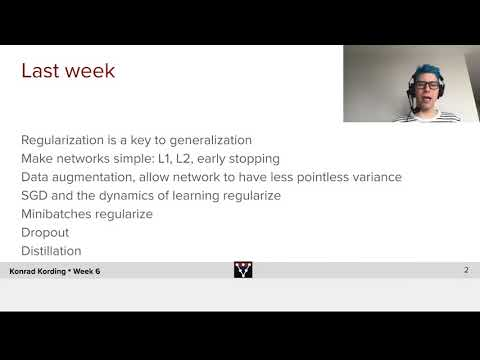

In [9]:
#@title Video: Discussing Week 5 - Regularization
import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="xMKKVMjQNhY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In [10]:
#@markdown Tell us your thoughts about what you have learned. What questions do you have?
last_week_recap = '' #@param {type:"string"}

---
# Section 1: Background on CNNs 

*Estimated Completion Time: 20 minutes from start of the tutorial*

Video available at https://youtube.com/watch?v=x-SYSSBmEX4


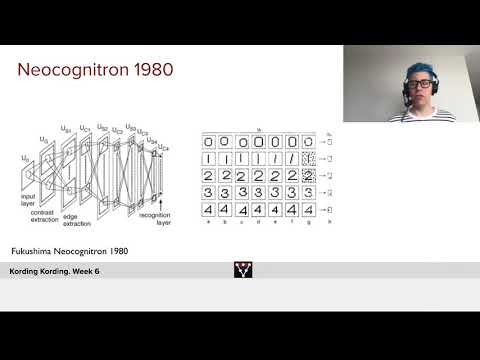

In [11]:
#@title Video: History of CNNs and Good Representations
import time
try: t1;
except NameError: t1=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="x-SYSSBmEX4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

At a high level, a CNN attempts to generate a feature representation of an image that can be used to determine what the object is. What does this mean exactly?<br> 
<br>
It means that the network will try to decipher which characteristics - for a human, it could be detection of two legs and strucutre of the face - are important to differentiate between objects. 

## Exercise 1 

In [12]:
#@markdown ImageNet is one of the largest image databases. Let us take 4 categories within this dataset - animal, plant, activity and food. What features do you think you would use to classifiy an image into one of these categories? Discuss with your pod.
imagenet_features = 'random imagenet features for all the classes' #@param {type:"string"}

---
# Section 2: Neural Analogy

*Estimated Completion Time: 30 minutes from start of the tutorial*

Video available at https://youtube.com/watch?v=cndkwecg52M


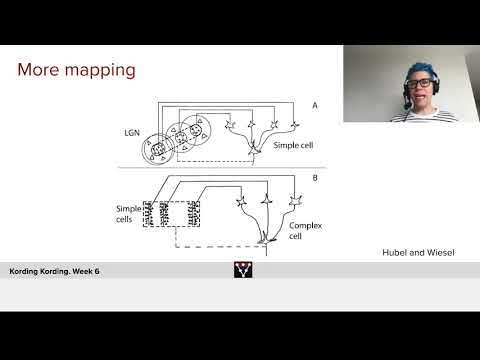

In [13]:
#@title Video: Electrophysiology Introduction
import time
try: t2;
except NameError: t2=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="cndkwecg52M", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Section 3: 
Imagine that you want to detect an object in an image. It seems reasonable that whatever method we use to recognize objects should not be overly concerned with the precise location of the object in the image. Ideally, our system should exploit this knowledge. Pigs usually do not fly and planes usually do not swim. Nonetheless, we should still recognize a pig were the one to appear at the top of the image. This is what we refer to as Spatial Invariance i.e the position of the object in the image does not play a role in recognizing the object itself.

*Estimated Completion Time: 35 minutes from start of the tutorial*

## Exercise 3

In [14]:
#@markdown Do you think the Fully Connected Networks that you have been using till now accomplishes this task? Why/Why not?
fcn_invariance = '' #@param {type:"string"}

---
#Section 4: Convolutions

*Estimated Completion Time: 65 minutes from start of the tutorial*

Video available at https://youtube.com/watch?v=5cbf6wRjvJc


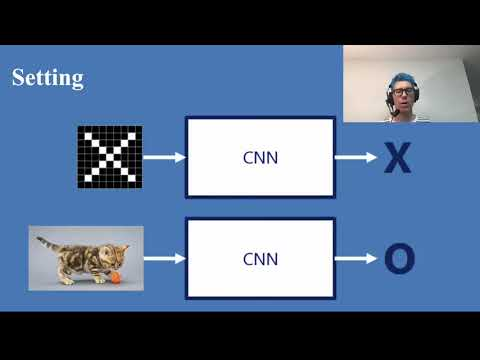

In [15]:
#@title Video: How to Perform Convolutions?
import time
try: t3;
except NameError: t3=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="5cbf6wRjvJc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Exercise 4.1: Perform Convolution by Hand

Do a convolution by hand using this simple 2x2 kernel. Discuss how the size of the output changes (assume no padding).

$$ \textbf{Image} = 
\begin{bmatrix}0 &1 &2 \\3 &4 &5 \\ 6 &7 &8   
\end{bmatrix} 
$$

$$ \textbf{Kernel} = 
\begin{bmatrix} 0 &1 \\2 & 3
\end{bmatrix} 
$$

## Exercise 4.2: Code a convolution.

Here we have given a function that performs a convolution on a provided image. Fill in the missing lines of code.

In [16]:
def convolution2d(image, kernel):
    m, n = kernel.shape
    # Note: We are dealing with a square kernel here, only for simplicity. It is very much possible to perform the same on kernels with different heights and widths!
    if (m == n):
        y, x = image.shape
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("perform the convolution")
        ####################################################################
        # Hint: x_op and y_op will be the output dimensions, initialize them
        y_op = ... 
        x_op = ...
        convolved_image = np.zeros((y_op, x_op))
        # Hint: Now perform the actual convolution
        for i in range(y_op):
            for j in range(x_op):
                ####################################################################
                # Fill in missing code below (...),
                # then remove or comment the line below to test your function
                raise NotImplementedError("perform the convolution")
                ####################################################################
                convolved_image[i][j] = ...
    
    return convolved_image

### Uncomment below to test your function
# image = np.arange(9).reshape(3, 3)
# print("Image:\n",image)
# kernel = np.arange(4).reshape(2, 2)
# print("Kernel:\n",kernel)
# print("Convolved output:\n",convolution2d(image, kernel))

In [17]:
# to_remove solution

def convolution2d(image, kernel):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y_op, x_op = image.shape
        y_op = y - m + 1
        x_op = x - m + 1
        convolved_image = np.zeros((y_op, x_op))
        for i in range(y_op):
            for j in range(x_op):
                convolved_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    
    return convolved_image


image = np.arange(9).reshape(3, 3)
print("Image:\n",image)
kernel = np.arange(4).reshape(2, 2)
print("Kernel:\n",kernel)
print("Convolved output:\n",convolution2d(image, kernel))

Image:
 [[0 1 2]
 [3 4 5]
 [6 7 8]]
Kernel:
 [[0 1]
 [2 3]]
Convolved output:
 [[19. 25.]
 [37. 43.]]


Great! At this point, you should have a fair idea how to perform a convolution on an image given a kernel. In the following cell, we will show you how you can set up a CNN to perform the exact same convolution as above.

In [18]:
class Net(nn.Module):
    def __init__(self, kernel=None, padding=0):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=padding)
        
      # set up kernel 
      if kernel is not None:
        dim1, dim2 = kernel.shape[0], kernel.shape[1]
        kernel = kernel.reshape(1, 1, dim1, dim2)
    
        self.conv1.weight = torch.nn.Parameter(kernel)
        self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))
              
    def forward(self, x):
      x = self.conv1(x)
      return x

In [19]:
kernel = torch.Tensor(np.arange(4).reshape(2, 2))
net = Net(kernel=kernel, padding=0).to(device)

In [20]:
# set up image 
image = torch.Tensor(np.arange(9).reshape(3, 3))
image = image.reshape(1, 1, 3, 3).to(device) # BatchSize X Channels X Height X Width

In [21]:
output = net(image)

In [22]:
output 

tensor([[[[19., 25.],
          [37., 43.]]]], device='cuda:0', grad_fn=<AddBackward0>)

As a quick aside, notice the difference in the input and output size. The input had a size of 3x3 and the output is of size 2x2. This is because the edges get missed out as then the kernel would be out of bounds of the image. If we don't want to lose that information, we will have to pad the image with 0s on the edges. This process is called padding.

In [23]:
net = Net(kernel=kernel, padding=1).to(device)
output = net(image)
output

tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], device='cuda:0', grad_fn=<AddBackward0>)

---
# Section 5: Edge Detection


*Estimated Completion Time: 80 minutes from start of the tutorial*


Video available at https://youtube.com/watch?v=mNbYB0C8OO0


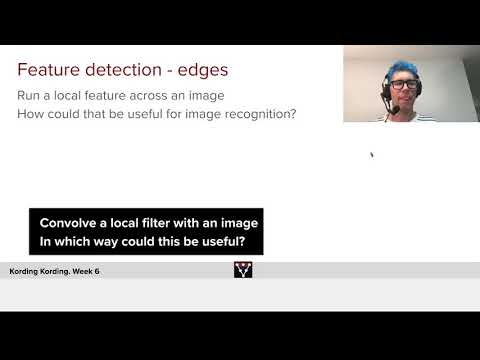

In [24]:
#@title Video: Padding and Edge Detection 
import time
try: t4;
except NameError: t4=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="mNbYB0C8OO0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

One of the simpler tasks performed by a convolution layer is edge detection by detecting the change in the value of pixels. This is usually learned by the first couple of layers in the network. Look at the following very simple kernel and discuss whether this will detect vertical or horizontal edges.


$$ \textbf{Kernel} = 
\begin{bmatrix} 1 & -1 \\ 1 & -1
\end{bmatrix} 
$$

## Exercise 5.1

In [25]:
#@markdown What kind of edges do you think this will generate?
edge_generate = '' #@param {type:"string"}

Here, we start with an image which has three vertical regions with the darker shade in the middle and the lighter shade in the surrounding regions. It can also be thought of as a very zoomed in vertical edge within an image!

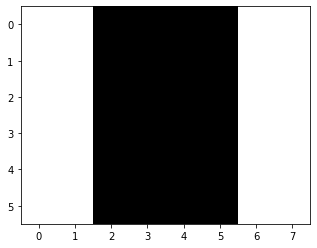

In [26]:
X = np.ones((6, 8))
X[:, 2:6] = 0
plt.imshow(X, cmap=plt.get_cmap('gray'))
plt.show()

In [27]:
image = torch.from_numpy(X)
image = image.reshape(1, 1, 6, 8) # BatchSize X Channels X Height X Width
kernel = torch.Tensor([[1.0, -1.0],[1.0, -1.0]])
net = Net(kernel=kernel)
edges = net(image.float())

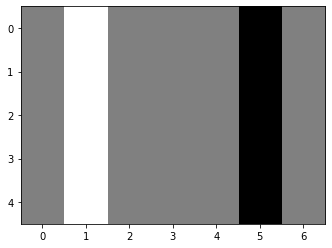

In [28]:
plt.imshow(edges.reshape(5, 7).detach().numpy(), cmap=plt.get_cmap('gray'))
plt.show()

The convolved output basically highlights both the vertical transitions in going from lighter shade to darker and going from darker to lighter. Thus, helping us detect the vertical edges in the input image.  

## Exercise 5.2

In [29]:
#@markdown As you can see, this kernel detects vertical edges. If the kernel was transposed, what would would be produced by running this kernel?
transpose_kernel = '' #@param {type:"string"}

We will come back to strides in the MaxPool section.

---
# Section 6: Visualizing the Primary Components of a CNN

*Estimated Completion Time: 110 minutes from start of the tutorial*

In order to visualize the various components of a CNN, we are going to build a simple CNN step by step. Remember, how we've already used the MNIST dataset that consisted of binary images of handwritten digits. This time we will be using the EMNIST letters dataset which consists of handwritten characters (A -> Z).

We will simply the problem further by only keeping the images that correspond to X (labelled as 24 in the dataset) and O (labelled as 15 in the dataset) and build a CNN that can classify an image as either X or O.

In [30]:
#@title Dataset/DataLoader Functions

# loading the dataset 
def get_Xvs0_dataset():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    emnist_train = datasets.EMNIST(root='./data', split='letters', download=True, train=True, transform=transform)
    emnist_test = datasets.EMNIST(root='./data', split='letters', download=True, train=False, transform=transform)

    # only want O (15) and X (24) labels 
    train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
    emnist_train.targets = emnist_train.targets[train_idx]
    emnist_train.data = emnist_train.data[train_idx]  

    # convert Xs predictions to 1, Os predictions to 0
    emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

    test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
    emnist_test.targets = emnist_test.targets[test_idx]
    emnist_test.data = emnist_test.data[test_idx]

    # convert Xs predictions to 1, Os predictions to 0
    emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

    return emnist_train, emnist_test

def get_data_loaders(train_dataset, test_dataset, batch_size=32):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)
    
    return train_loader, test_loader


In [31]:
emnist_train, emnist_test = get_Xvs0_dataset()

Extracting ./data/EMNIST/raw/emnist.zip to ./data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [32]:
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test)

In [33]:
# index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0

Let's view a couple samples from the dataset.

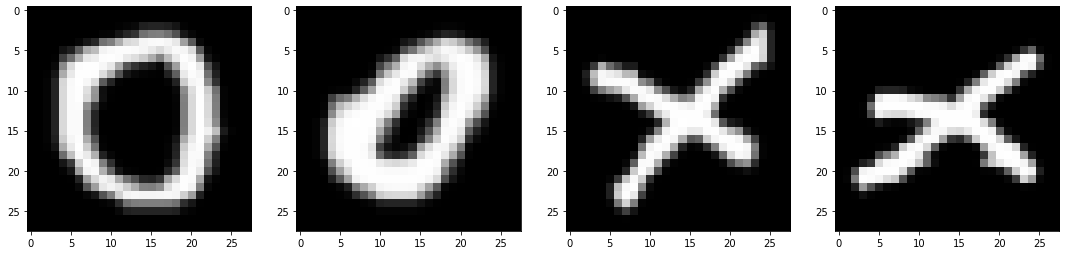

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(emnist_train[4][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

Great! Now, its time to watch a video explaining the different components of a CNN.

Video available at https://youtube.com/watch?v=kMCZKMbT5rk


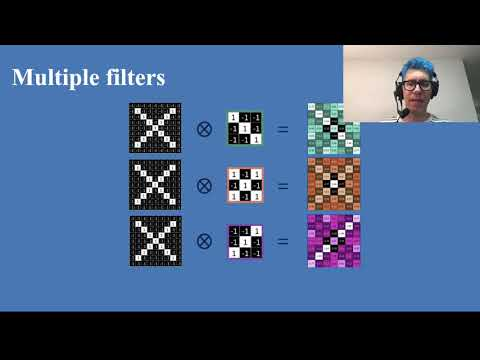

In [35]:
#@title Video: Multiple Filters, ReLU and Max Pool
import time
try: t5;
except NameError: t5=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="kMCZKMbT5rk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Section 6.1 Multiple Filters

The following network sets up 3 filters and runs them on an X image of the dataset.

In [37]:
class Net2(nn.Module):
    def __init__(self, kernel=None, padding=0):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=padding)
        
        # first kernel - leading diagonal
        kernel_1 = torch.unsqueeze(torch.Tensor([[1, -1, -1], [-1, 1, -1], [-1, -1, 1]]), 0)

        # second kernel -checkerboard pattern
        kernel_2 = torch.unsqueeze(torch.Tensor([[1, -1, 1], [-1, 1, -1], [1, -1, 1]]), 0)

        # third kernel - other diagonal
        kernel_3 = torch.unsqueeze(torch.Tensor([[-1, -1, 1], [-1, 1, -1], [1, -1, -1]]), 0)

        multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

        self.conv1.weight = torch.nn.Parameter(multiple_kernels)
        self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))
              
    def forward(self, x):
      x = self.conv1(x)
      return x

In [38]:
net2 = Net2().to(device)

In [39]:
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
output_x = net2(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(device)
output_o = net2(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()


Let us view the image of X and O, that we want to run the filters on.

ORIGINAL IMAGES


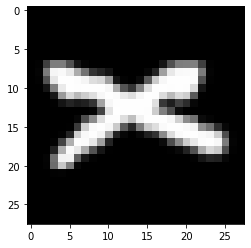

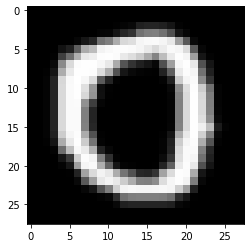

In [40]:
print("ORIGINAL IMAGES")
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

CONVOLVED IMAGES


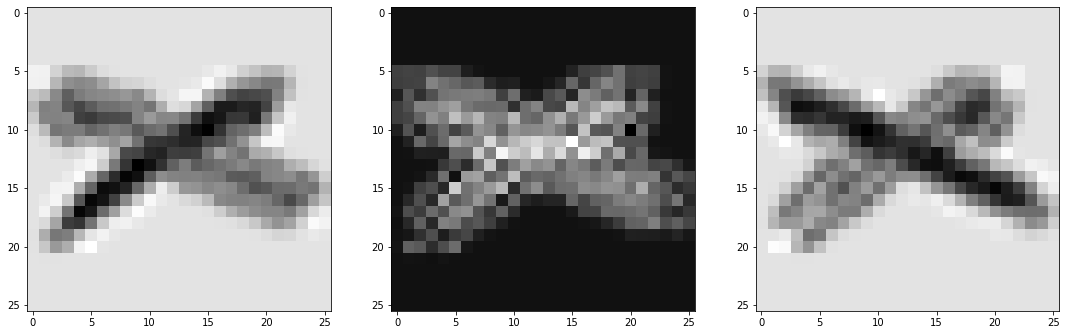

In [41]:
print("CONVOLVED IMAGES")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_x[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_x[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_x[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

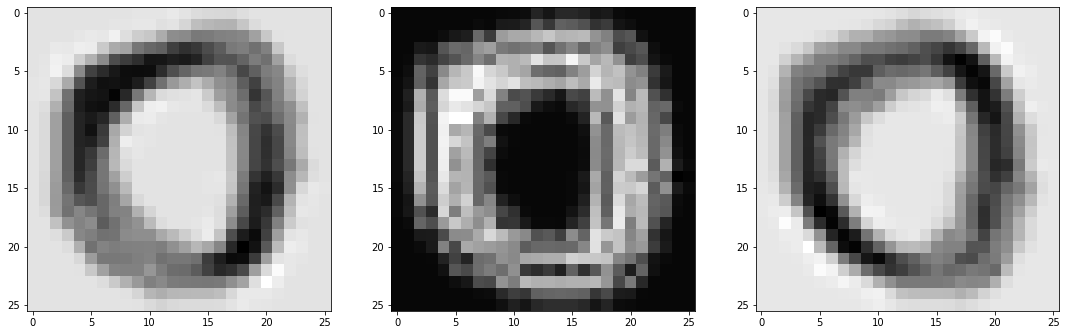

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_o[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_o[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_o[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

## Exercise 6.1

In [43]:
#@markdown Do you see how these filters would help recognize an X?
multiple_filters = 'multiple filters sample response, 95 mins elapsed' #@param {type:"string"}

## Section 6.2 ReLU after convolutions

Note that the convolutional operation is still linear in nature, however, the inputs to our CNNs which we want to correctly identify and learn are  naturally non-linear and complex. The purpose of applying the rectifier function is to increase the non-linearity in our model which wants to learn complex features typically from an image. x.

When you look at any image, you'll find it contains a lot of non-linear features (e.g. the transition between pixels, the borders, the colors, etc.).

The rectifier serves to break up the linearity even further in order to make up for the linearity that we might impose an image when we put it through the convolution operation. To see how that actually plays out, we can look at the following picture and see the changes that happen to it as it undergoes the convolution operation followed by rectification.


Now let us apply ReLU to our previous model and visualize it.

In [44]:
class Net3(nn.Module):
    def __init__(self, kernel=None, padding=0):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=padding)
        
        # first kernel - leading diagonal
        kernel_1 = torch.unsqueeze(torch.Tensor([[1, -1, -1], [-1, 1, -1], [-1, -1, 1]]), 0)

        # second kernel - checkerboard pattern
        kernel_2 = torch.unsqueeze(torch.Tensor([[1, -1, 1], [-1, 1, -1], [1, -1, 1]]), 0)

        # third kernel - other diagonal
        kernel_3 = torch.unsqueeze(torch.Tensor([[-1, -1, 1], [-1, 1, -1], [1, -1, -1]]), 0)

        multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

        self.conv1.weight = torch.nn.Parameter(multiple_kernels)
        self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))
              
    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      return x

In [45]:
net3 = Net3().to(device)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
output_x = net3(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(device)
output_o = net3(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

RECTIFIED OUTPUTS


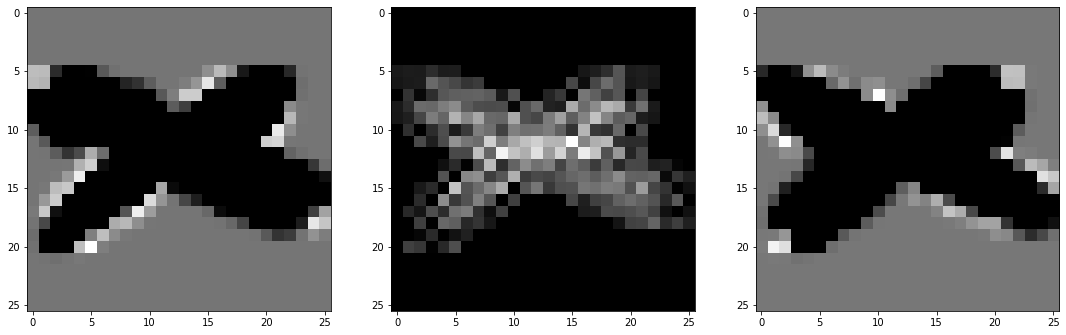

In [48]:
print("RECTIFIED OUTPUTS")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_x[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_x[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_x[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

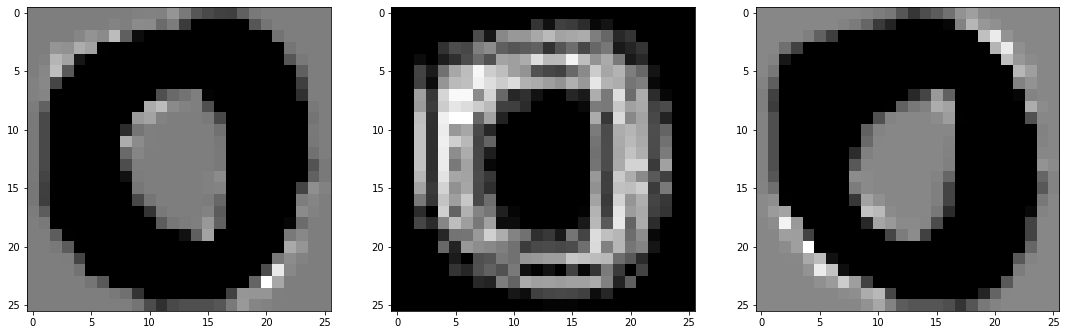

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_o[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_o[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_o[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

Discuss how the ReLU activations help strengthen the features necessary to detect an X.


## Section 6.3: Pooling

Convolutional layers in a convolutional neural network systematically apply learned filters to input images in order to create feature maps that summarize the presence of those features in the input. However, a limitation of the feature map output of convolutional layers is that they record the precise position of features in the input. This means that small movements in the position of the feature in the input image will result in a different feature map. This can happen with re-cropping, rotation, shifting, and other minor changes to the input image.

A common approach to addressing this problem from signal processing is called down sampling. This is where a lower resolution version of an input signal is created that still contains the large or important structural elements, without the fine detail that may not be as useful to the task. This also translates to the problem of having too many features in the output of the connvoltional layers, and techniques such as Max Pooling and average Pooling are used to downsample, thereby shrinking the layers, the number of features and bringing spatial invariance of features. 

Like convolutional layers, pooling operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape window (sometimes known as the pooling window). 

Thus, it is a  method of information compression where we replace the output of a convolutional neural network at the pixel level with the summary statistics of its neighbors.
- In Maxpooling, we replace each pixel with the maximum value in its immediate neighbors fitting inside the pooling kernel.
- In Avgpooling, we replace each pixel with the average value in its immediate neighbors fitting inside the pooling kernel.

<figure>
    <center><img src=https://developers.google.com/machine-learning/glossary/images/PoolingConvolution.svg?hl=fr width=400px>
    <figcaption>An Example of Pooling with a kernel size of 2</figcaption>
    </center>
</figure>

Pooling helps us maintain translational invariance in our network as it selects the statistical summary of the values residing in the kernel space. Thus, A small displacement of the value contributing primarily to that summary does not make a huge difference.

Note that the pooling layer contains no parameters (there is no kernel), unlike the convolutional layer. 


We usually use MaxPool with a stride of two in order to lower the dimensionality. This is essentially how we downsample. The following two pictures depicts how stride makes a difference.




<figure>
    <center><img src=https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif>
    <figcaption> Stride 1 </figcaption>
    </center>    
</figure>


<figure>
    <center><img src=https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif>
    <figcaption> Stride Two </figcaption>
    </center>    
</figure>


## Exercise 6.2: Implement MaxPooling 

Let us now implement MaxPooling in PyTorch and observe the efects of Pooling on the dimension of the input image. Use a kernel of size 2 and stride of 2.

In [50]:
class Net3(nn.Module):
    def __init__(self, kernel=None, padding=0, stride=2):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=padding)
        
        # first kernel 
        kernel_1 = torch.unsqueeze(torch.Tensor([[1, -1, -1], [-1, 1, -1], [-1, -1, 1]]), 0)

        # second kernel 
        kernel_2 = torch.unsqueeze(torch.Tensor([[1, -1, 1], [-1, 1, -1], [1, -1, 1]]), 0)

        # third kernel 
        kernel_3 = torch.unsqueeze(torch.Tensor([[-1, -1, 1], [-1, 1, -1], [1, -1, -1]]), 0)

        multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

        self.conv1.weight = torch.nn.Parameter(multiple_kernels)
        self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Define the maxpool layer")
        ####################################################################
        # Hint: Use nn.Maxpool2D
        self.pool = ...
              
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Define the maxpool layer")
        ####################################################################
        x = ...
        return x

### Uncomment the lines below to run the network and then run the next cell
### to plot the images  
# net = Net3().to(device)
# x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
# output = net(x_img)
# output = output.squeeze(dim=0).detach().cpu().numpy()

In [51]:
# to_remove solution
class Net3(nn.Module):
    def __init__(self, kernel=None, padding=0, stride=2):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=padding)
        
        # first kernel 
        kernel_1 = torch.unsqueeze(torch.Tensor([[1, -1, -1], [-1, 1, -1], [-1, -1, 1]]), 0)

        # second kernel 
        kernel_2 = torch.unsqueeze(torch.Tensor([[1, -1, 1], [-1, 1, -1], [1, -1, 1]]), 0)

        # third kernel 
        kernel_3 = torch.unsqueeze(torch.Tensor([[-1, -1, 1], [-1, 1, -1], [1, -1, -1]]), 0)

        multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

        self.conv1.weight = torch.nn.Parameter(multiple_kernels)
        self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))
        self.pool = nn.MaxPool2d(2, stride=stride)
              
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        return x

net = Net3().to(device)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
output_x = net(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(device)
output_o = net(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

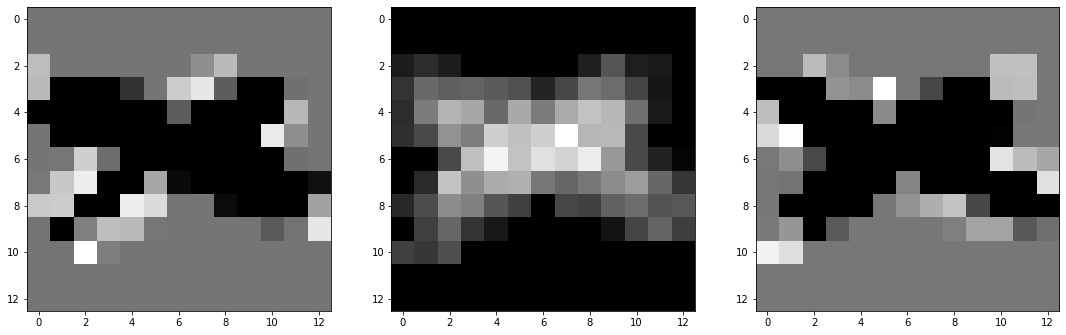

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_x[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_x[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_x[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

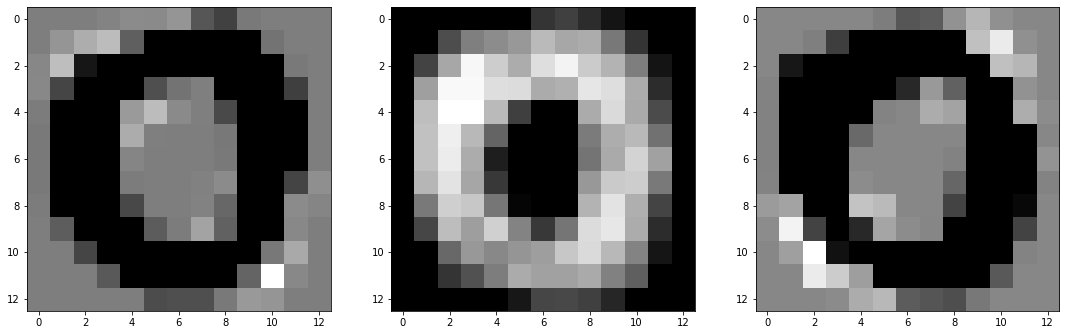

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(output_o[0], cmap=plt.get_cmap('gray'))
ax2.imshow(output_o[1], cmap=plt.get_cmap('gray'))
ax3.imshow(output_o[2], cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

You should observe the size of the output as being half of what you saw after the ReLU section, which is due to the Maxpool layer. 

Inspite of the reduction in the size of the output, the important or high level feature in the output still remain intact. 

---
# Section 7: Number of Parameters in CNNs
*Estimated Completion Time: 125 minutes from start of the tutorial*



Video available at https://youtube.com/watch?v=oJN_migdZus


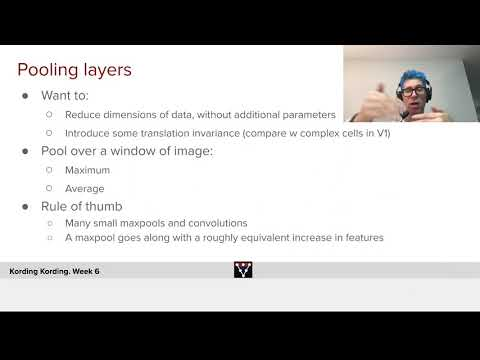

In [54]:
#@title Video: Reduction in Parameters to Learn Compared to Fully Connected Networks
import time
try: t6;
except NameError: t6=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="oJN_migdZus", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Exercise 7: Number of parameters in Convolutional vs Fully connected Models
Convolutional Networks encourage weight sharing by learning a single kernel that is repeated over the entire input image. In general this kernel is barely a few parameters as compared to the huge number of parameters in a linear network. Let's calculate the parameters of a few layer network on random image data of shape $32\times32$ using both conv layers and linear layers. The Num_Linears in this exercise is the number of linear layers we use in the network, with each linear layer having the same input and output dimensions, while the Num_Convs is the number of Convolutional blocks we make use of, with each block containing a single kernel. The kernel size is the length and width of this kernel. 


<figure>
    <center><img src=https://raw.githubusercontent.com/CIS-522/course-content/W6/tutorials/W6_ConvNets/img_params.png>
    <figcaption> Parameter comparison </figcaption>
    </center>    
</figure>

In [55]:
#@title Reduced_Params == Reduced_time_to_train

batch_size= 1 #@param {type:"integer"}
sample_image=torch.rand(batch_size,1,32,32)
print("Input Shape {}".format(sample_image.shape))

Num_Linears = 1 #@param {type:"slider", min:1, max:3, step:1}
linear_layer = []
for i in range(Num_Linears):
    linear_layer.append(nn.Linear(32*32*1,32*32*1,bias=False))
linear_layer = nn.Sequential(*linear_layer)

kernel_size= 3 #@param {type:"slider", min:3, max:21, step:2}

Num_Convs = 1 #@param {type:"slider", min:1, max:20, step:1}

conv_layer = []
conv_layer.append(nn.Conv2d(in_channels=1,out_channels=3,kernel_size=kernel_size,padding=True,bias=False))
for i in range(Num_Convs-1):
    conv_layer.append(nn.Conv2d(in_channels=3,out_channels=3,kernel_size=kernel_size,padding=True,bias=False))
conv_layer = nn.Sequential(*conv_layer)


t_1=time.time()
print("\nOutput From Linear {}".format(linear_layer(torch.flatten(sample_image,1)).shape))
t_2=time.time()
print("Output From Conv Layer {}".format(conv_layer(sample_image).shape))
t_3=time.time()

print("Time taken by Linear Layer {}".format(t_2-t_1))
print("Time taken by Conv Layer {}".format(t_3-t_2))
print("\nTime Performance improvement by Conv Layer {:.2f} %".format(((t_2-t_1)-(t_3-t_2))*100.0/(t_2-t_1)))


print("\nTotal Parameters in Linear Layer {}".format(sum(p.numel() for p in linear_layer.parameters())))
print("Total Parameters in Conv Layer {}".format(sum(p.numel() for p in conv_layer.parameters())))


del linear_layer,conv_layer

Input Shape torch.Size([1, 1, 32, 32])

Output From Linear torch.Size([1, 1024])
Output From Conv Layer torch.Size([1, 3, 32, 32])
Time taken by Linear Layer 0.0010552406311035156
Time taken by Conv Layer 0.004979372024536133

Time Performance improvement by Conv Layer -371.87 %

Total Parameters in Linear Layer 1048576
Total Parameters in Conv Layer 27


The difference in parameters is huge and keeps on multiplying as the input image size increases as the linear layer tries to build a matrix that can be directly multiplied with the input pixels.

<br>

The CNN paramater size, however is invariant of the image size, as irrespective of the input that it gets, it keeps sliding the same learnable filter over the images. <br>The reduced parameter set not only brings down memory usage by huge chunks, but also allows the model to generalize better.


---
# Section 8: Stacking up the Layers





Video available at https://youtube.com/watch?v=vX4u3gQN730


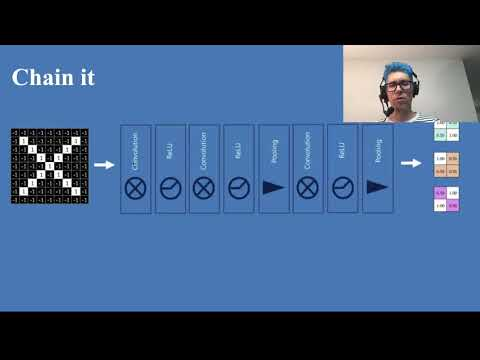

In [56]:
#@title Video: Putting it All Together
import time
try: t7;
except NameError: t7=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="vX4u3gQN730", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In [57]:
#@title Train/Test Functions

def train(model, device, train_loader, epochs):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.01)
    for epoch in range(epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                sleep(0.1)

def test(model, device, data_loader):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

## Exercise 8: Implement your own CNN.

Let's stack up all we have learnt. Create a CNN with the following structure. <br>
- Convolution (input_channel=1, output_channels=32, kernel_size=3)
- Convolution (input_channel=32, output_channels=64, kernel_size=3)
- Pool Layer 
- Fully Connected Layer (9216, 128)
- Fully Connected layer (128, 2)

Note: As discussed in the video, we would like to flatten the output from the Convolutional Layers before passing on the Linear layers, thereby converting an input of shape [BatchSize, Channels, Height, Width] to [BatchSize, Channels\*Height\*Width], which in this case would be from [32, 64, 12, 12] (output of second convolution layer) to [32, 64\*12\*12] = [64, 9216].<br> Hint: You could use torch.flatten in order to flatten the input at this stage. 



Also, don't forget the ReLUs! No need to add to a ReLU after the final fully connected layer.

 
 *Estimated Completion Time: 140 minutes from start of the tutorial*



In [58]:
class EMNIST_Net(nn.Module):
    def __init__(self):
        super(EMNIST_Net, self).__init__()

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Define the required layers")
        ####################################################################
        self.conv1 = nn.Conv2d(...)
        self.conv2 = nn.Conv2d(...)
        self.fc1 = nn.Linear(...)
        self.fc2 = nn.Linear(...)
        self.pool = nn.MaxPool2d(...)

    def forward(self, x):
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # Hint: Do not forget to flatten the image as it goes from Convolution Layers to Linear Layers!
        raise NotImplementedError("Define forward pass for any input x")
        ####################################################################

 ### Uncomment the lines below to train your network   
# emnist_net = EMNIST_Net().to(device)
# train(emnist_net, device, train_loader, 1)

In [59]:
# to_remove solution
class EMNIST_Net(nn.Module):
    def __init__(self):
        super(EMNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)        
        x = self.fc2(x)
        return x

emnist_net = EMNIST_Net().to(device)
train(emnist_net, device, train_loader, 1)

Now, let's run the network on the test data!

In [60]:
test(emnist_net, device, test_loader)

99.1875

You should have been able to get a test accuracy ~ 99%!

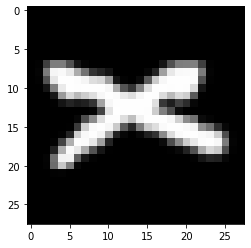

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


tensor([[0.0012, 0.9988]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [61]:
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(x_img)
F.softmax(output)

The network is quite confident that this image is an X ! <br>Note that this is evident from the Softmax Output, which shows the probabilities of the image belonging to each of the classes. A higher probability of belonging to class 1 i.e. class X. <br><br>Let us also test the network against an O image. 

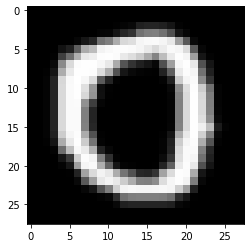

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


tensor([[9.9915e-01, 8.4766e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [62]:
x_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(device)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(o_img)
F.softmax(output)

Again, the predicted label is correct for the O image. 

# Submit your responses
Please run the following cell and then press "Submit" so we can record your responses.

In [67]:
import time
import numpy as np
from IPython.display import IFrame
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()
try: t7;
except NameError: t7 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_pod;
except NameError: my_pod = "Select"

try: last_week_recap;
except NameError: last_week_recap = ""

try: imagenet_features;
except NameError: imagenet_features = ""

try: fcn_invariance;
except NameError: fcn_invariance = ""

try: edge_generate;
except NameError: edge_generate = ""

try: transpose_kernel;
except NameError: transpose_kernel = ""

try: multiple_filters;
except NameError: multiple_filters = ""

times = np.array([t1, t2,t3,t4,t5,t6,t7])-t0

fields = {"my_pennkey": my_pennkey,
          "my_pod": my_pod,
          "last_week_recap":last_week_recap,
          "imagenet_features": imagenet_features,
          "fcn_invariance":fcn_invariance,
          "edge_generate": edge_generate,
          "transpose_kernel":transpose_kernel,
          "multiple_filters":multiple_filters,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrBAPp6Ma1khiT4I?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))

## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [68]:
display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))